# Natural Language Processing of 2016 President Election Debate Speech

### Basic utilization of nltk, stopwords, Term Occurrence, Feature Extraction, and on-the-fly multi-model evaluation!

The purpse for this notebook is to use NLP to classify a speaker based on words used from the transcript while using multi-models quickly. 

Info on Term Occurence from Sci-kit Learn: http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html 

Step 1: Import basic packages + make sure stopwords are downloaded. Use nltk.download() for nltk packages. 


In [16]:
import pandas as pd
import nltk  
import matplotlib.pylab as plt
#nltk.download() - Use only when need a package
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import TweetTokenizer
from sklearn.model_selection import train_test_split

#Take a quick look at the data
df = pd.read_csv("debate.csv", encoding = "ISO-8859-1")
df.head()

,Line,Speaker,Text,Date
0,1,Holt,Good evening from Hofstra University in Hempst...,9/26/16
1,2,Audience,(APPLAUSE),9/26/16
2,3,Clinton,"How are you, Donald?",9/26/16
3,4,Audience,(APPLAUSE),9/26/16
4,5,Holt,Good luck to you.,9/26/16


#### Step 2: 

Set-up stopwords, target (t1), and random seed for preprocessing section. This will remove all stop words from the dataframe, as well columns 'Line' and 'Date' which we are not using. Import_cleanse() reads in the file, drops columns, filters for 'Clinton' and 'Trump' transcripts only. (Modify this for other speakers). Finally, using train_test_split() we split the data into 80/20 for training and validation of our models. 

In [78]:
######### Params Set-Up #############################
""" stopwords, target, and random seed settings """ #
stop_words = set(stopwords.words('english'))        #
                                                    #
t1 = 'Speaker'                                      #
SEED = 1253                                         #
#####################################################

""" Pre-Processing Functions """
def remove_stopwords(sen, stopwords=stop_words):
    punct = [',','.',"'",'!',';','?','-']
    tt = TweetTokenizer()
    tokens = tt.tokenize(sen)
    tokens = [w for w in tokens if w not in stopwords and w not in punct]
    return " ".join(tokens)


def import_cleanse():
    """ :input_file = set file pwd at main
    """
    df = pd.read_csv("debate.csv", encoding = "ISO-8859-1")
    #Dropping line index and Date from this analysis
    df.drop('Line', axis=1, inplace=True)
    df.drop('Date', axis=1, inplace=True)
    
    #Applying remove_stopwords
    df['Text'] = df['Text'].apply(remove_stopwords)
    return df


def traintestsplit(filtered=None):
    #Bring in cleaned data
    data = import_cleanse()
    
    # Adding filter option for later
    if filtered == None:
        data = data[(data['Speaker'] == 'Trump') | (data['Speaker'] == 'Clinton')]
    elif filtered == 'OFF':
        data = data[(data['Speaker'] != 'QUESTION') & (data['Speaker'] != 'CANDIDATES')]
    
    # Continue with splitting...
    X_train, X_validation = train_test_split(data, 
                                             test_size=0.20, 
                                             random_state = SEED)
    y_train = (X_train[[t1]])              
    X_train = X_train.drop([t1], axis=1)   

    y_validation = (X_validation[[t1]])             
    X_validation = X_validation.drop([t1], axis=1)
    
    
    return X_train, X_validation, y_train, y_validation

# Final step returning df's for training and validation 
X_train, X_validation, y_train, y_validation = traintestsplit()

In [53]:
#y_train.groupby(['Speaker']).count()

#### Step 3:

In this step we will define a function to iterate through multiple machine learning models on-the-fly. This allows for a quick way to easily evaluate and multiple models at once. (recommened for relatively small datasets, or sampling) The function will use model.predict and we can see the results & performance from confusion_matrix and accuracy.

NOTE: Each classifier is using out-of-the-box parameters. 

In [20]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import model_selection

def nlp_models(select==None):
    """
    :clfs: machine leanring objects from sci-kit learn. ex. "classifier()".
    :title: name of model used for output descriptions. 
    :X: features
    :y: targets
    """
    
    clfs = [MultinomialNB(), BernoulliNB(), RandomForestClassifier(), MLPClassifier(), 
            KNeighborsClassifier(), SVC()]
    title = ['MultinomialNB', 'BernoulliNB', 'RandomForestClassifier', 'MLPClassifier', 'KNN', 'SVC']
    
    # Run through multiple models!
    for t, clf in zip(title, clfs):
        model = make_pipeline(TfidfVectorizer(), clf)
        model.fit(X_train['Text'], y_train['Speaker'])
        pred = model.predict(X_validation['Text'])
        print(t,"Performance")
        print("=========================")
        print(model.classes_)
        print(confusion_matrix(y_validation['Speaker'], pred))
        print("Accurracy:", accuracy_score(y_validation['Speaker'], pred)) 
        print("")   

# Run the function...
nlp_models()

('MultinomialNB', 'Performance')
[u'Clinton' u'Trump']
[[20 29]
 [ 1 70]]
('Accurracy:', 0.75)

('BernoulliNB', 'Performance')
[u'Clinton' u'Trump']
[[18 31]
 [ 0 71]]
('Accurracy:', 0.7416666666666667)

('RandomForestClassifier', 'Performance')
[u'Clinton' u'Trump']
[[32 17]
 [20 51]]
('Accurracy:', 0.6916666666666667)

('MLPClassifier', 'Performance')
[u'Clinton' u'Trump']
[[31 18]
 [ 6 65]]
('Accurracy:', 0.8)

('KNN', 'Performance')
[u'Clinton' u'Trump']
[[25 24]
 [11 60]]
('Accurracy:', 0.7083333333333334)

('SVC', 'Performance')
[u'Clinton' u'Trump']
[[ 0 49]
 [ 0 71]]
('Accurracy:', 0.5916666666666667)



We can see that the MultiLayerPerceptron (MLP) performs the best. 

#### Step 4: K-fold Cross Validation 

Here we will utilize K-fold cross validation. Cross-validation is a statistical method used to estimate the repeated performance of machine learning models. It is a resampling procedure used to evaluate the models on a limited data sample. - This will go through the same process as the function above except it will use 10-fold splitting for CV and we will be able to plot the accuracy of each model to compare algorithms. 

In [79]:
results = []
names = []
scoring = 'accuracy'

def CV_testing():
    """
    :clfs: machine leanring objects from sci-kit learn. ex. "classifier()".
    :title: name of model used for output descriptions. 
    :X: features
    :y: targets
    """
    
    clfs = [MultinomialNB(), BernoulliNB(), RandomForestClassifier(), MLPClassifier(), 
            KNeighborsClassifier(), SVC()]
    title = ['Multinomial', 'Bernoulli', 'RandForest', 'MLP', 'KNN', 'SVC']
    
    print("Running 2nd pass with 10-Fold CV: ")
    for t, clf in zip(title, clfs):
        model = make_pipeline(TfidfVectorizer(), clf)
        model.fit(X_train['Text'], y_train['Speaker'])
        
        # K-fold and CV process
        kfold = model_selection.KFold(n_splits=10, random_state=SEED)
        cv_results = model_selection.cross_val_score(model, X_train['Text'], 
                                                     y_train['Speaker'], 
                                                     cv=kfold, 
                                                     scoring=scoring)
        results.append(cv_results)
        names.append(t)
        msg = "%s: %f (%f)" % (t, cv_results.mean(), cv_results.std())
        print(msg)
        
# boxplot algorithm comparison
    fig = plt.figure(figsize=(10,5))
    fig.suptitle('Algorithm Comparison 10-fold CV')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()  

Running 2nd pass with 10-Fold CV: 
Multinomial: 0.769902 (0.066424)
Bernoulli: 0.732402 (0.060969)
RandForest: 0.719770 (0.042267)
MLP: 0.820213 (0.083288)
KNN: 0.778413 (0.057103)
SVC: 0.594238 (0.077746)


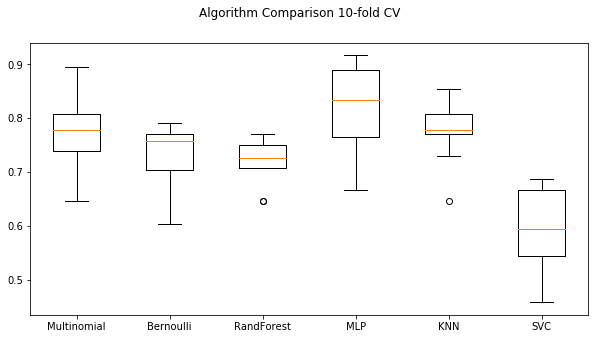

In [80]:
CV_testing()

## Testing MLP on all Speakers for Fun

Here we will try to classify multiple speakers from the TF-id vectorizer... We will use the MLP to do this since it permormed well previously. 

('MLPClassifier', 'Performance')
[u'Audience' u'Clinton' u'Cooper' u'Holt' u'Kaine' u'Pence' u'Quijano'
 u'Raddatz' u'Trump' u'Wallace']
('Accurracy:', 0.6179775280898876)

             precision    recall  f1-score   support

   Audience       1.00      1.00      1.00        11
    Clinton       0.69      0.62      0.65        56
     Cooper       0.64      0.64      0.64        11
       Holt       0.53      0.50      0.52        16
      Kaine       0.61      0.48      0.54        23
      Pence       0.38      0.39      0.38        23
    Quijano       0.83      0.45      0.59        11
    Raddatz       0.62      0.33      0.43        15
      Trump       0.63      0.75      0.68        75
    Wallace       0.53      0.69      0.60        26

avg / total       0.63      0.62      0.61       267

Confusion matrix, without normalization
[[11  0  0  0  0  0  0  0  0  0]
 [ 0 35  0  0  1  2  0  1 14  3]
 [ 0  0  7  0  0  1  0  0  1  2]
 [ 0  2  0  8  0  1  0  1  2  2]
 [ 0  2  0  0 11

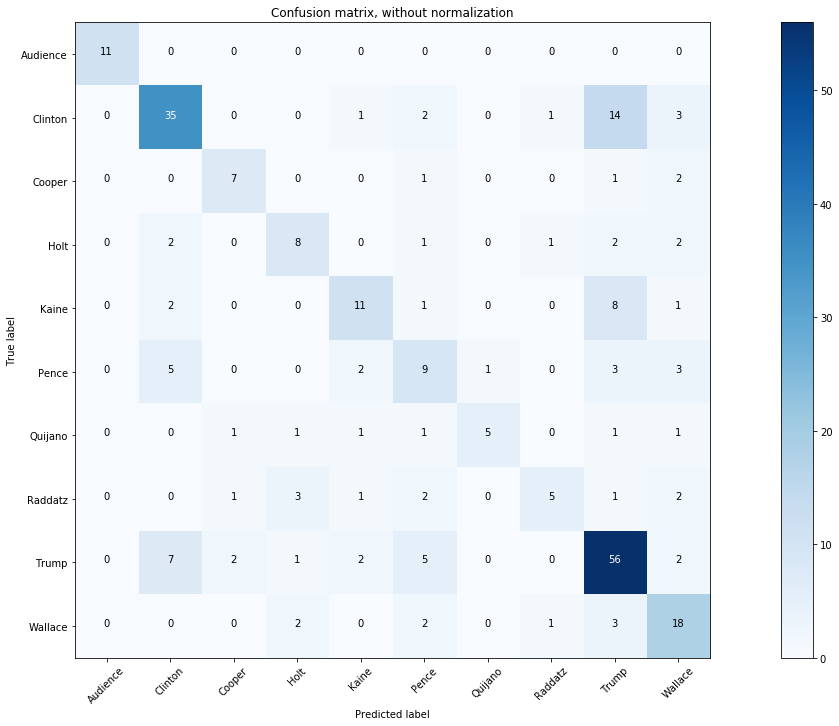

In [77]:
import numpy as np
import itertools

from sklearn.metrics import classification_report

# First set up nicer confusion matrix plot for viewing multi-classes

class_names = ['Audience', 'Clinton','Cooper','Holt','Kaine' ,'Pence','Quijano','Raddatz', 'Trump', 'Wallace']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#############################################################################
#Load train test split
X_train, X_validation, y_train, y_validation = traintestsplit(filtered='OFF')
#############################################################################

def nlp_models(select=None):
    """
    :clfs: MLP
    :title: name of model used for output descriptions. 
    :X: features
    :y: targets
    """
    
    clfs = [ MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)]
    
    title = ['MLPClassifier']
    
    # Run through multiple models!
    for t, clf in zip(title, clfs):
        model = make_pipeline(TfidfVectorizer(), clf)
        model.fit(X_train['Text'], y_train['Speaker'])
        pred = model.predict(X_validation['Text'])
        print(t,"Performance")
        print("=========================")
        print(model.classes_)
        #print(confusion_matrix(y_validation['Speaker'], pred))
        print("Accurracy:", accuracy_score(y_validation['Speaker'], pred)) 
        print("")   
        
        print(classification_report(y_validation['Speaker'], pred, target_names=class_names))
        # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_validation['Speaker'], pred)
    np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
    plt.figure(figsize=(20,10))
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Run the function...
nlp_models()